In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '..')
from DataModule.Data_Preparation import CoronnaCERTAINDataset
import evaluate 

import xgboost as xgb
from sklearn.linear_model import LinearRegression

(CVXPY) Jun 27 11:37:02 AM: Encountered unexpected exception importing solver CVXOPT:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so, 0x0002): tried: '/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e'))")
(CVXPY) Jun 27 11:37:02 AM: Encountered unexpected exception importing solver GLPK:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so, 0x0002): tried: '/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e'))")
(CVXPY) Jun 27 11:37:02 AM: Encountered unexpected exception importing solver GLPK_MI:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/e

/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
dataset = CoronnaCERTAINDataset(
    library_root='/Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/',
    challenge="two_stage", #option: regression, classification, two_stage
    dataset='CORRONA CERTAIN', 
    process_approach='SC', #option: KVB, SC
    imputation='KNN', #option: SimpleFill, KNN, SoftImpute, BiScaler, NuclearNormMinimization, IterativeImputer, IterativeSVD
    patient_group='bionaive TNF', #option: "all", "bioexp nTNF", "bionaive TNF", "bionaive orencia", "KVB"
    drug_group='all', #option: "all", "actemra", "cimzia", "enbrel", "humira", "orencia", "remicade", "rituxan", "simponi"
    time_points=(0,3), 
    train_test_rate=0.8,
    save_csv=False, 
    random_state=2022)

feature engineering, drop columns due to 70% missing value: Index(['smkyrs', 'numcigs', 'rfstatus_impute', 'ccpstatus_impute',
       'statin_use'],
      dtype='object')
Imputing row 1/1498 with 0 missing, elapsed time: 0.362
Imputing row 101/1498 with 1 missing, elapsed time: 0.362
Imputing row 201/1498 with 0 missing, elapsed time: 0.363
Imputing row 301/1498 with 0 missing, elapsed time: 0.363
Imputing row 401/1498 with 0 missing, elapsed time: 0.364
Imputing row 501/1498 with 1 missing, elapsed time: 0.364
Imputing row 601/1498 with 0 missing, elapsed time: 0.364
Imputing row 701/1498 with 0 missing, elapsed time: 0.365
Imputing row 801/1498 with 0 missing, elapsed time: 0.365
Imputing row 901/1498 with 0 missing, elapsed time: 0.366
Imputing row 1001/1498 with 1 missing, elapsed time: 0.366
Imputing row 1101/1498 with 0 missing, elapsed time: 0.367
Imputing row 1201/1498 with 0 missing, elapsed time: 0.367
Imputing row 1301/1498 with 0 missing, elapsed time: 0.367
Imputing row 14

In [3]:
# read train, test from dataloader
train, train_loc = dataset.get_train()
test, test_loc = dataset.get_test()

In [4]:
train

,grp,age,gender,final_education,race_grp,ethnicity,weight,BMI,height,newsmoker,...,md_global_assess,pt_global_assess,di,pt_pain,usresultsCRP,usresultsIgA,usresultsIgG,usresultsIgM,DAS28_CRP_0M,DAS28_CRP_3M
0,1.0,54.0,1.0,0.0,7.0,1.0,225.0,31.377703,71.0,3.0,...,50.0,25.0,0.285714,25.0,1.64,144.000000,886.000000,113.000000,3.189429,1.733190
1,1.0,54.0,0.0,0.0,7.0,1.0,175.0,28.242654,66.0,3.0,...,35.0,17.0,0.250000,25.0,1.19,207.000000,1010.000000,56.000000,2.935127,2.473876
2,1.0,63.0,0.0,0.0,7.0,1.0,117.0,20.080811,64.0,0.0,...,40.0,10.0,0.000000,5.0,0.40,190.000000,657.000000,100.000000,2.698947,3.386822
3,1.0,61.0,0.0,0.0,7.0,1.0,240.0,39.933728,65.0,2.0,...,55.0,50.0,0.250000,60.0,1.00,44.000000,948.000000,51.000000,3.719481,4.444948
4,1.0,64.0,1.0,0.0,7.0,1.0,294.0,41.000198,71.0,2.0,...,55.0,55.0,0.285714,70.0,16.74,178.000000,882.000000,87.000000,5.146565,2.846272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,1.0,42.0,0.0,2.0,7.0,1.0,156.0,29.472722,61.0,0.0,...,55.0,80.0,1.000000,80.0,7.33,353.000000,859.000000,211.000000,5.167880,3.685886
342,2.0,49.0,0.0,0.0,1.0,1.0,220.0,33.447232,68.0,2.0,...,35.0,50.0,0.000000,15.0,22.36,266.000000,1330.000000,253.000000,4.272186,4.459125
343,1.0,24.0,0.0,0.0,1.0,1.0,128.0,20.045444,67.0,2.0,...,75.0,60.0,0.500000,60.0,6.47,289.000000,1800.000000,188.000000,4.333871,2.109117
344,2.0,61.0,0.0,0.0,7.0,1.0,125.0,20.798817,65.0,0.0,...,35.0,15.0,0.000000,15.0,0.92,163.000000,1500.000000,44.000000,3.283134,1.047585


In [5]:
# get x,y train and test set
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1] # train.iloc[:,-2]
X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1] # test.iloc[:,-2]

In [6]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 321 entries, 0 to 345
Series name: DAS28_CRP_3M
Non-Null Count  Dtype  
--------------  -----  
321 non-null    float64
dtypes: float64(1)
memory usage: 5.0 KB


In [7]:
# initialize evaluation module
aml = evaluate.AutoBuild(seed=1, project_name="EHR_RA_SC")
baseline = test['DAS28_CRP_0M']
true = test['DAS28_CRP_3M']

In [8]:
# modelmodule
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)
aml.evaluate("xgb", baseline, true, pred)

/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [9]:
# linear model
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
aml.evaluate("lr", baseline, true, pred)

In [10]:
regression, classification = aml.leaderboard()

In [11]:
regression

,model,MAE,MSE,RMSE,R2,Pearson_Correlation
0,xgb,1.026149,1.596995,1.263723,0.188836,0.483459
1,lr,1.037648,1.643516,1.281997,0.165207,0.450617


In [12]:
classification

,model,Accuracy,F1-Score
0,xgb,0.50000,0.50000
1,lr,0.44186,0.44186


In [13]:
# rows: true, columns: pred
aml.confusion_matrix("xgb")

,Good,Moderate,No Response
Good,13,14,3
Moderate,6,22,3
No Response,4,13,8


In [14]:
# true
aml.saved_model['xgb'][0].value_counts()

Moderate       31
Good           30
No Response    25
dtype: int64

In [15]:
# pred
aml.saved_model['xgb'][1].value_counts()

Moderate       49
Good           23
No Response    14
dtype: int64

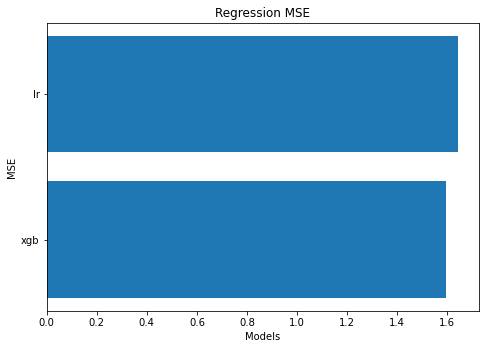

In [16]:
aml.plot_results('regression')

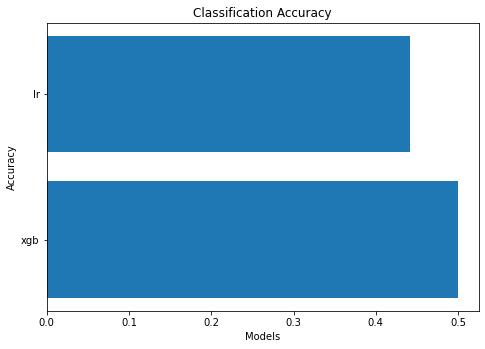

In [17]:
aml.plot_results('classification')